In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from etrago import Etrago
from etrago import tools
from etrago.tools.plot import (
    coloring, 
    make_legend_circles_for, 
    make_handler_map_to_scale_circles_as_in,
    plot_grid,
    calc_storage_expansion_per_bus,
)
import matplotlib.patches as mpatches
colors = coloring

Import networks

In [4]:
etrago_H2share0 = Etrago(csv_folder_name= "../../results_0_case")
network_H2share0 = etrago_H2share0.network.copy()

# etrago_H2share50 = Etrago(csv_folder_name= "../../results_50_case")
# network_H2share50 = etrago_H2share50.network.copy()

# etrago_ch4_load_abroad = Etrago(csv_folder_name= "RES/results_eGon2035_lowflex_nofeedin_CH4loads")
# network_ch4_load_abroad = etrago_ch4_load_abroad.network.copy()

INFO:pypsa.io:Imported network results_0_case has buses, generators, lines, links, loads, storage_units, stores
c:\ProgramData\mambaforge\envs\etrago_envW\lib\site-packages\pypsa\io.py:96: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  df["snapshot"] = pd.to_datetime(df.snapshot)
c:\ProgramData\mambaforge\envs\etrago_envW\lib\site-packages\pypsa\io.py:110: DtypeWarning: Columns (0,16) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(fn, index_col=0, encoding=self.encoding)
INFO:pypsa.io:Imported network clustering has buses, lines, links


In [5]:
networks = {
    "H2_0": network_H2share0,
    # "H2_50": network_H2share50,
}

label = {
    "H2_0": "eGon2035",
    # "H2_50": "50% H2 feedin",
}

In [6]:
buses_DE = {}
for key in networks:
    buses_DE[key] = networks[key].buses.loc[networks[key].buses.country == 'DE']

# Tests

In [7]:
for key in networks:
    print(networks[key])

PyPSA Network
Components:
 - Bus: 2735
 - Generator: 2794
 - Line: 530
 - Link: 6731
 - Load: 1693
 - StorageUnit: 323
 - Store: 1606
Snapshots: 1752


In [8]:
for key in networks:
    print(networks[key].links.carrier.unique())

['rural_heat_pump' 'BEV charger' 'dsm' 'power_to_H2' 'central_heat_pump'
 'central_resistive_heater' 'DC' 'OCGT' 'CH4' 'central_heat_store_charger'
 'central_heat_store_discharger' 'rural_heat_store_discharger'
 'H2_to_power' 'rural_heat_store_charger' 'central_gas_CHP'
 'industrial_gas_CHP' 'central_gas_CHP_heat' 'central_gas_boiler'
 'CH4_to_H2' 'H2_to_CH4']


## Insights
The number of Links decreases when not allowing for H2 feedin. -> No H2_feedin links (67) which is intended 

In [65]:
for key in networks:
    # print(networks[key].buses.carrier.unique())
    # print(networks[key].stores.carrier.unique())
    # print(networks[key].links.carrier.unique())
    print(networks[key].loads.carrier.unique())
    # print(networks[key].generators.carrier.unique())

    # print(networks[key].buses.carrier.value_counts())
    # print(networks[key].links.carrier.value_counts())
    # print(networks[key].stores.carrier.value_counts())
    # print(networks[key].loads.carrier.value_counts())
    # print(networks[key].generators.carrier.value_counts())

['AC' 'H2_for_industry' 'CH4' 'central_heat' 'rural_heat'
 'land transport EV' 'CH4_for_industry' 'rural_gas_boiler' 'H2_hgv_load']


# H2

## H2 production

In [10]:
SMR = {}
ELY = {}

for key in networks:
    SMR[key] = networks[key].links[(networks[key].links.carrier == "CH4_to_H2")]
    ELY[key] = networks[key].links[(networks[key].links.carrier == "power_to_H2")]

In [11]:
H2_dispatch_SMR = {}
H2_dispatch_ELY = {}

for key in networks:
    H2_dispatch_SMR[key] = - networks[key].links_t.p1[SMR[key].index]
    H2_dispatch_ELY[key] = - networks[key].links_t.p1[ELY[key].index]

C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\3894868279.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


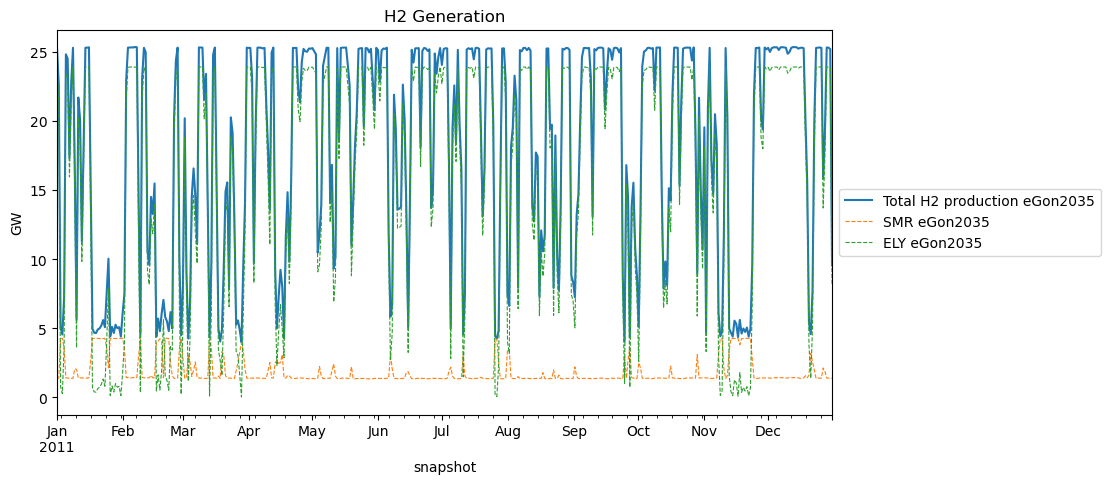

In [12]:
total_dispatch = {}

fig, ax = plt.subplots(figsize = (10,5))

for key in networks:
    total_dispatch[key] = H2_dispatch_SMR[key].sum(axis = 1) + H2_dispatch_ELY[key].sum(axis = 1)

    (total_dispatch[key]/1e3).resample('20H').mean().plot(
        ax=ax, 
        label=("Total H2 production "+label[key]), 
        legend=True)
    (H2_dispatch_SMR[key]/1e3).sum(axis = 1).resample('20H').mean().plot(
        ax=ax, 
        label=("SMR "+label[key]),
        linestyle='dashed',
        linewidth=0.8,
        legend=True
    )
    (H2_dispatch_ELY[key]/1e3).sum(axis = 1).resample('20H').mean().plot(
        ax=ax, 
        label=("ELY "+label[key]),
        linestyle='dashed',
        linewidth=0.8,
        legend=True
    )


ax.set_ylabel('GW')
ax.set_title('H2 Generation')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.show()

### ELY: power to H2

In [13]:
for key in networks:
    print(label[key])
    print(f'Total H2 production by power_to_H2 (in GW): {H2_dispatch_ELY[key].sum().sum()/1e3:.2f}')
    print(f'Total power_to_H2 capacity built (in GW): {ELY[key].p_nom_opt.sum()/1e3:.2f}, (with efficiency: {(ELY[key].p_nom_opt.sum()/1e3)*(ELY[key].efficiency.mean()):.2f} GW)')
    print(f'Total SMR capacity built (in GW): {SMR[key].p_nom_opt.sum()/1e3:.2f}, (with efficiency: {(SMR[key].p_nom_opt.sum()/1e3)*(SMR[key].efficiency.mean()):.2f} GW) \n')

eGon2035
Total H2 production by power_to_H2 (in GW): 27975.75
Total power_to_H2 capacity built (in GW): 34.15, (with efficiency: 23.90 GW)
Total SMR capacity built (in GW): 5.78, (with efficiency: 4.28 GW) 



## Insights
- The total H2 production is for both scenarios almost the same. Oddly the H2 production is a little higher if there is no H2_feedin to the methane grid allowed (likely insignificant). 
- The build up of SMR and ELY is anticorrelated between the two scenarios.
- Ratio from SMR to ELY for no H2 feedin: 4.28 / 23.90 -> 1:5.58
- Ratio from SMR to ELY for 50% H2 feedin: 3.81 / 24.11 -> 1:6.33
- Are there real differences in the solutions? Are this just two local optima?
- marginal_cost of SMR is 0 (capital_cost 38354.07); not a result
- marginal_cost of ELY is 0 (capital_cost 24049.54); not a result
- Question: Why is there any SMR at all? Is there not enough power available? Are the ELY capacities capped -> not everywhere? Are there exisiting SMR capacities prior to optimization -> NO? There is even SMR build when the p_nom_max for ELY is inf. Why? Are there lines which run at full capacity and an extension is more expensive than building SMR capacities? Check time; efficiencies; Check Gesamtkosten ergebnisse Clara, was ist mit h2_to_ch4

Calculate efficiencies: 
34.15, (with efficiency: 23.90 GW)
5.78, (with efficiency: 4.28 GW) 
€ per GW ELY: 34.15 * 24049.54 / 23.90 GW = 34,363.67
€ per GW SMR: 5.15 * 38354.07 / 3.81 GW = 51,843.42

In [14]:
a = network_H2share0.links[(network_H2share0.links.carrier=='power_to_H2') & (network_H2share0.links.p_nom_max != np.inf)].bus1
b = network_H2share0.links[(network_H2share0.links.carrier=='power_to_H2') & (network_H2share0.links.p_nom_max == np.inf)].bus1

# -> Even if ELY p_nom_extendable is np.inf at a bus, there is still SMR

<AxesSubplot: xlabel='snapshot'>

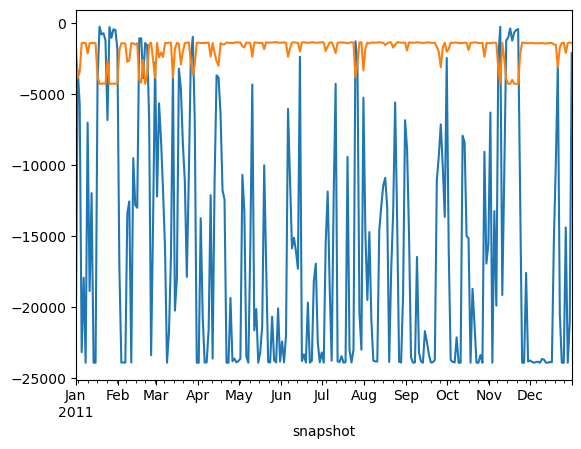

In [15]:
ax = network_H2share0.links_t.p1[network_H2share0.links[network_H2share0.links.carrier=='power_to_H2'].index].sum(axis=1).resample('35H').mean().plot()
network_H2share0.links_t.p1[network_H2share0.links[network_H2share0.links.carrier=='CH4_to_H2'].index].sum(axis=1).resample('35H').mean().plot(ax = ax)

# -> This is anticorrelated; Is ELY capped at these timesteps? How to I calculate the maximum possible ELY?

In [16]:
len(network_H2share0.links[network_H2share0.links.bus1.isin(a)][network_H2share0.links[network_H2share0.links.bus1.isin(a)].carrier =='CH4_to_H2'].p_nom_opt)

66

C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\217922647.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


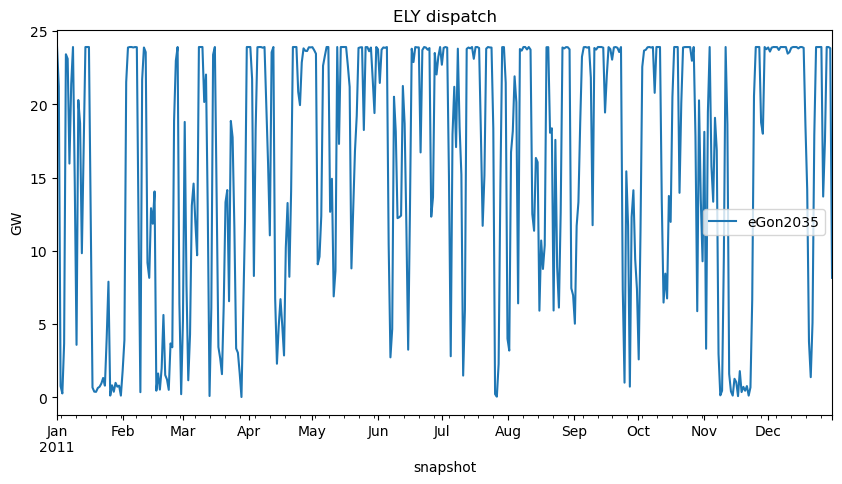

In [17]:
fig, ax = plt.subplots(figsize = (10,5))

for key in networks:
    (H2_dispatch_ELY[key]/1e3).sum(axis = 1).resample('20H').mean().plot(ax=ax, label=(label[key]), legend=True)

ax.set_ylabel('GW')
ax.set_title('ELY dispatch')

fig.show()

#### Spatial repartition

4.264400398666504e-06
50.471519162454435


C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\1698266452.py:64: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


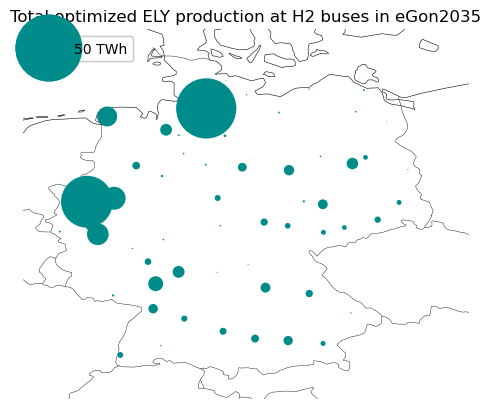

In [18]:
ely_capacities_h2 = {}
ely_h2_bus = {}

for key in networks:

    ely_h2_bus[key] = ELY[key]["bus1"]
    ely_capacities_h2[key] = H2_dispatch_ELY[key].sum(axis=0)
    new_idx = [ely_h2_bus[key][i] for i in ely_capacities_h2[key].index.to_list()]
    ely_capacities_h2[key] = pd.Series(ely_capacities_h2[key].values,index = new_idx).groupby(level=0).sum()
    
    scaling = 5/1e6

    bus_scaling = 1/1e2
    bus_sizes = ely_capacities_h2[key] * scaling
    bus_unit = "TWh"

    print(bus_sizes.min())
    print(bus_sizes.max())

    handles = make_legend_circles_for([
        # bus_sizes.min()*bus_scaling, 
        bus_sizes.max()*bus_scaling,
        ], 
        scale=1, 
        facecolor=colors()["H2_to_power"]
    )
    labels = [#"min", "max"]
        ("{} " + bus_unit).format(s)
        for s in (
            # round(bus_sizes.min()),
            round(bus_sizes.max()),
        )
    ]

    network = networks[key].copy()
    network.buses = network.buses[
        (network.buses.carrier == "H2_grid")
        # | (network.buses.carrier == "H2_saltcavern")
    ]

    fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})
    network.plot(
        bus_sizes=bus_sizes*bus_scaling,
        line_widths=0,
        link_widths=0,
        margin=0.1,
        ax=ax,
        bus_colors=colors()["H2_to_power"], 
        title=("Total optimized ELY production at H2 buses in "+label[key]))


    l2 = ax.legend(
    handles,
    labels,
    loc='upper left',
    # bbox_to_anchor=(0.01, 1.01),
    labelspacing=1.0,
    framealpha=1.0,
    # title=bus_legend,
    handler_map=make_handler_map_to_scale_circles_as_in(ax),
    )
    ax.add_artist(l2)

    fig.show()

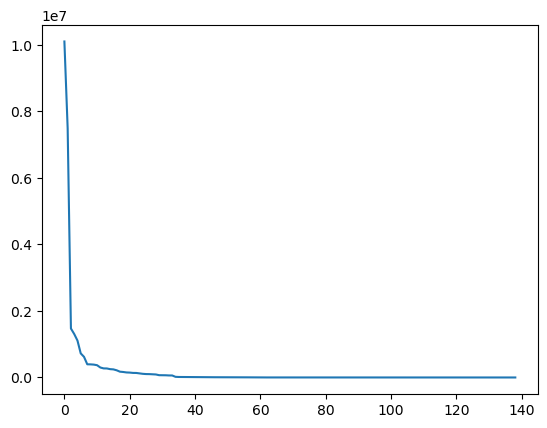

In [19]:
fig,ax = plt.subplots(1)
for key in networks:
    ax.plot(np.sort(ely_capacities_h2[key].values)[::-1])


## Insights
- If there is H2_feedin allowed, the spatial distribution of ELY is more evenly spread across Germany and there is no more central ELY (Mega)Hub near Hamburg.
- Why? What is special about HH / Oberhausen?
- Both of the buses have also the highest and second highest H2_to_CH4 (methanization) capacities
- Spatial repartition of CH4 (look 'CH4' plots) does not show any special properties of these two buses
- Investigate this further?

In [20]:
network_H2share0.links.loc[network_H2share0.links.carrier == 'power_to_H2'].p_nom_opt.sort_values()

# bus1 of the links with high ELY capacities: 86192 (HH), 86193 (Oberhausen)
# bus1 of the resp. methanization: 86112(HH), 86113 (Obernhausen)

Link
755         0.003648
325         0.003783
1025        0.003784
151         0.003785
547         0.003787
            ...     
1228     1323.499592
1229     1538.539023
1637     1812.335100
1035     9735.417799
295     12494.993067
Name: p_nom_opt, Length: 374, dtype: float64

In [21]:
a = []
for i in network_H2share0.buses[network_H2share0.buses.carrier == 'CH4'].index:
    a.append([i,len(network_H2share0.links.loc[network_H2share0.links.bus0==i])])

In [22]:
print(a)

[['48621', 7], ['48622', 7], ['48623', 3], ['48624', 4], ['48625', 5], ['48626', 6], ['48627', 4], ['48628', 1], ['48629', 8], ['48630', 2], ['48631', 5], ['48632', 1], ['48634', 1], ['86109', 45], ['86110', 24], ['86111', 69], ['86112', 49], ['86113', 97], ['86114', 42], ['86115', 31], ['86116', 14], ['86117', 31], ['86118', 40], ['86119', 23], ['86120', 47], ['86121', 45], ['86122', 28], ['86123', 19], ['86124', 34], ['86125', 33], ['86126', 53], ['86127', 25], ['86128', 25], ['86129', 19], ['86130', 26], ['86131', 71], ['86132', 21], ['86133', 64], ['86134', 45], ['86135', 56], ['86136', 19], ['86137', 51], ['86138', 45], ['86139', 7], ['86140', 18], ['86141', 16], ['86142', 33], ['86143', 81], ['86144', 39], ['86145', 10], ['86146', 45], ['86147', 41], ['86148', 17], ['86149', 15], ['86150', 56], ['86151', 44], ['86152', 33], ['86153', 37], ['86154', 32], ['86155', 9], ['86156', 21], ['86157', 30], ['86158', 27], ['86159', 29], ['86160', 29], ['86161', 37], ['86162', 13], ['86163',

In [23]:
network_H2share0.links.loc[network_H2share0.links.bus0=='86112']

,scn_name,bus0,bus1,carrier,p_nom,p_nom_extendable,p_nom_max,capital_cost,length,geom,...,p_max_pu,marginal_cost,p_nom_opt,country,build_year,lifetime,p_set,terrain_factor,ramp_limit_up,ramp_limit_down
Link,,,,,,,,,,,,,,,,,,,,,
3349,eGon2035,86112,131,industrial_gas_CHP,1.177000,False,inf,0.000000,0.000000,NaN,...,1.0,4.150000,1.177000,NaN,0,inf,0.0,1.0,NaN,NaN
3350,eGon2035,86112,135,central_gas_CHP,66.751117,False,inf,0.000000,0.000000,NaN,...,1.0,4.120000,66.751117,NaN,0,inf,0.0,1.0,NaN,NaN
3351,eGon2035,86112,135,industrial_gas_CHP,223.699135,False,inf,0.000000,0.000000,NaN,...,1.0,4.150000,223.699135,NaN,0,NaN,0.0,1.0,NaN,NaN
3352,eGon2035,86112,157,central_gas_CHP,2.463000,False,inf,0.000000,0.000000,NaN,...,1.0,4.150000,2.463000,NaN,0,NaN,0.0,1.0,NaN,NaN
3353,eGon2035,86112,157,industrial_gas_CHP,1.723069,False,inf,0.000000,0.000000,NaN,...,1.0,4.150000,1.723069,NaN,0,NaN,0.0,1.0,NaN,NaN
3354,eGon2035,86112,184,central_gas_CHP,50.000000,False,inf,0.000000,0.000000,NaN,...,1.0,4.000000,50.000000,NaN,0,inf,0.0,1.0,NaN,NaN
3355,eGon2035,86112,184,industrial_gas_CHP,0.170000,False,inf,0.000000,0.000000,NaN,...,1.0,4.150000,0.170000,NaN,0,inf,0.0,1.0,NaN,NaN
3356,eGon2035,86112,19,central_gas_CHP,20.505000,False,inf,0.000000,0.000000,NaN,...,1.0,4.100000,20.505000,NaN,0,NaN,0.0,1.0,NaN,NaN
3357,eGon2035,86112,19,industrial_gas_CHP,2.066736,False,inf,0.000000,0.000000,NaN,...,1.0,4.150000,2.066736,NaN,0,NaN,0.0,1.0,NaN,NaN


In [24]:
network_H2share0.links.loc[network_H2share0.links.carrier =='H2_to_CH4'].p_nom_opt.sort_values()

Link
5759       0.004681
5752       0.004683
5787       0.004684
5849       0.004684
5813       0.004684
           ...     
5586     907.836278
5876     949.048291
5658    1178.276639
5562    6682.627928
5545    8681.678986
Name: p_nom_opt, Length: 67, dtype: float64

#### Dispatch

In [25]:
# ely_capacities_sorted_ac = {}
# power_bus_ELY_id  = {}

# for key in networks:
#     ely_capacities_sorted_ac[key] = ely_capacities_ac[key].sort_values(ascending=False)
#     power_bus_ELY_id[key] = [i for i in ely_capacities_sorted_ac[key].index.to_list()[:1]]
#     print(power_bus_ELY_id[key])

In [26]:
# ELY_t_ac = {}

# for key in networks:
#     # ELY_group = 
#     ELY_t_ac[key] = networks[key].links_t.p0[ELY[key][ELY[key]["bus0"].isin(power_bus_ELY_id[key])].index]
    
#     fig, ax = plt.subplots(figsize = (10,5))
#     for i in ELY_t_ac[key].columns:
#         ELY_t_ac[key][[i]].plot(ax=ax, label=i, legend=True)
#     fig.show()

In [27]:
# ely_capacities_sorted_h2 = {}
# h2_bus_ELY_id  = {}

# for key in networks:
#     ely_capacities_sorted_h2[key] = ely_capacities_h2[key].sort_values(ascending=False)
#     h2_bus_ELY_id[key] = [i for i in ely_capacities_sorted_h2[key].index.to_list()[:1]]
#     print(h2_bus_ELY_id[key])

In [28]:
# ELY_t_h2 = {}

# for key in networks:
#     # ELY_group = 
#     ELY_t_h2[key] = - networks[key].links_t.p1[ELY[key][ELY[key]["bus1"].isin(h2_bus_ELY_id[key])].index]
    
#     fig, ax = plt.subplots(figsize = (10,5))
#     for i in ELY_t_h2[key].columns:
#         ELY_t_h2[key][[i]].plot(
#             ax=ax, 
#             label=i,
#             legend=True,
#             )
#     fig.show()

### SMR: CH4 to H2

In [90]:
for key in networks:
    print(f'Total H2 production by SMR for "{label[key]}" (in GW): {H2_dispatch_SMR[key].sum().sum()/1e3:.3f}')

Total H2 production by SMR for "eGon2035" (in GW): 3268.983


C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\2727229795.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


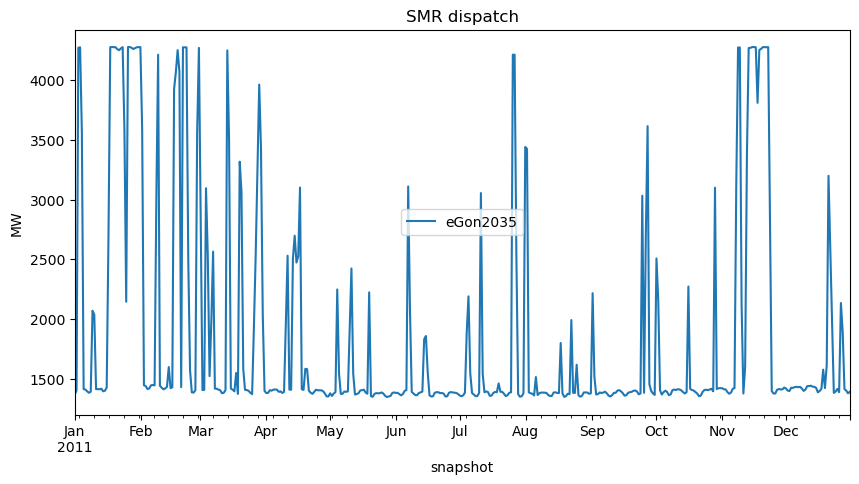

In [30]:
fig, ax = plt.subplots(figsize = (10,5))

for key in networks:
    H2_dispatch_SMR[key].sum(axis = 1).resample('20H').mean().plot(ax=ax, label=(label[key]), legend=True)

ax.set_ylabel('MW')
ax.set_title('SMR dispatch')

fig.show()

### Insights
The timeseries data for SMR dispatch is highly correlated between the two scenarios. Like hinted in the build capacities only the level on H2 production through SMR is different with higher SMR dispatch when no H2 feedin is allowed.

C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\2650538758.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


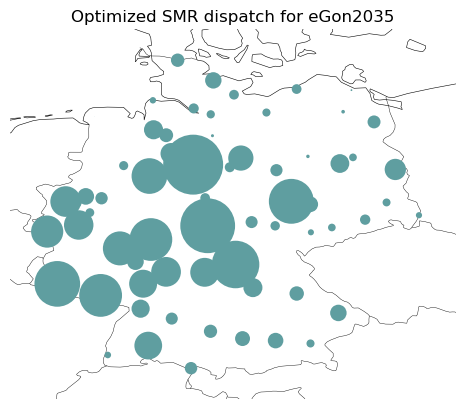

In [31]:
capacities = {}
H2_bus = {}
scaling = {}

for key in networks:

    H2_bus[key] = SMR[key]["bus1"]
    capacities[key] = H2_dispatch_SMR[key].sum(axis=0)
    new_idx = [H2_bus[key][i] for i in capacities[key].index.to_list()]
    capacities[key] = pd.Series(capacities[key].values,index = new_idx)
    scaling[key] = 1/capacities[key].max()

    network = networks[key].copy()
    network.buses = network.buses[(network.buses.carrier == "H2_grid")]

    fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})
    network.plot(
        bus_sizes=capacities[key] * scaling[key]/2,#/100000,
        line_widths=0,
        link_widths=0,
        margin=0.1,
        ax=ax,
        title=("Optimized SMR dispatch for "+label[key]),
    )
    fig.show()


## Insights
There looks to be no significant difference in the spatial SMR distribution that is related the allowed percentage of H2_feedin into the gas grid.

In [32]:
# capacities_sorted = {}
# H2_bus_SMR_id  = {}

# for key in networks:
#     capacities_sorted[key] = capacities[key].sort_values(ascending=False)
#     H2_bus_SMR_id[key] = [i for i in capacities_sorted[key].index.to_list()[:5]]

# print(H2_bus_SMR_id)

In [33]:
# SMR_t = {}

# for key in networks:
#     SMR_t[key] = -networks[key].links_t.p1[SMR[key][SMR[key]["bus1"].isin(H2_bus_SMR_id[key])].index]
    
#     fig, ax = plt.subplots(figsize = (10,5))
#     for i in SMR_t[key].columns:
#         SMR_t[key][[i]].plot(ax=ax, label=i, legend=True)
#     fig.show()

## H2 uses

C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\1478029705.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


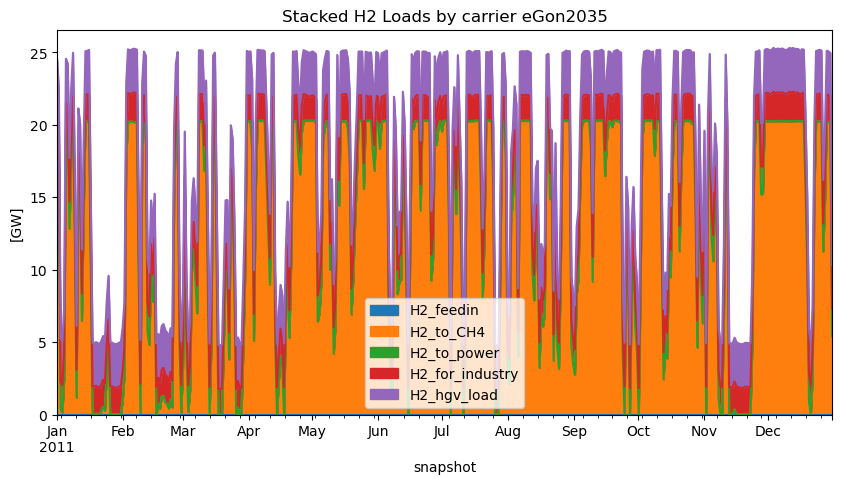

In [34]:
rel_h2_links_carriers = ['H2_feedin', 'H2_to_CH4', 'H2_to_power']
rel_h2_loads_carriers = ['H2_for_industry', 'H2_hgv_load']

H2_use = {}

for key in networks:
    # Links consuming H2
    H2_use[key] = networks[key].links_t.p0[networks[key].links.loc[networks[key].links.carrier == rel_h2_links_carriers[0]].index.to_list()]
    H2_use[key] = pd.DataFrame(H2_use[key].sum(axis=1))
    H2_use[key] = H2_use[key].rename(columns={0:rel_h2_links_carriers[0]})

    for i in rel_h2_links_carriers[1:]:
        h2_loads = networks[key].links_t.p0[networks[key].links.loc[networks[key].links.carrier == i].index.to_list()]
        H2_use[key][i] = h2_loads.sum(axis=1)

    # H2 loads
    DE_loads = networks[key].loads.loc[networks[key].loads.bus.isin(buses_DE[key].index)]
    for i in rel_h2_loads_carriers:
        h2_loads = networks[key].loads_t.p[DE_loads.loc[DE_loads.carrier == i].index.to_list()]
        H2_use[key][i] = h2_loads.sum(axis=1)
    
    # Plot
    fig = plt.figure(figsize=(10,5)) #, dpi=300
    (H2_use[key].resample('20H').mean()/1e3).plot.area(
        ax = plt.gca(), 
        title='Stacked H2 Loads by carrier '+label[key], 
        ylabel = "[GW]", 
        legend=True, 
        # stacked=True,
    )
    fig.show()

## Insights
It looks like if we dont allow for direct H2_feedin the H2 is converted into CH4 before further usage

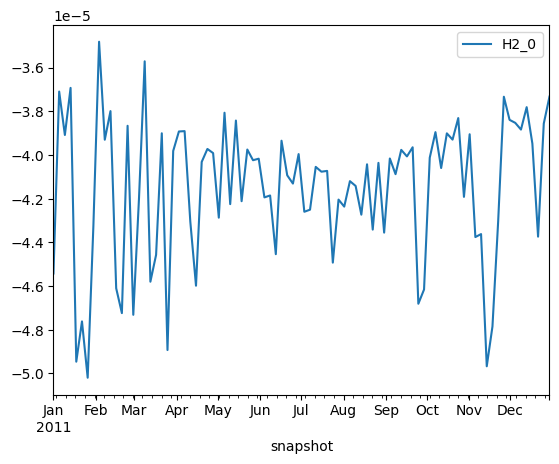

In [35]:
for key in networks:
    (networks[key].links_t.p1[networks[key].links.loc[networks[key].links.carrier=='H2_to_power'].index].sum(axis=1).resample('100h').mean()/1e3).plot(legend=True, label = key)

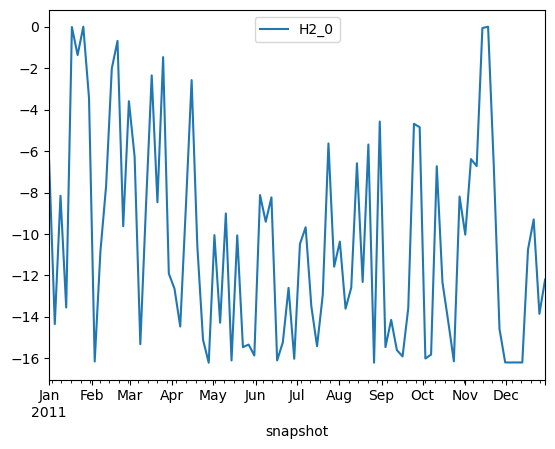

In [36]:
for key in networks:
    (networks[key].links_t.p1[networks[key].links.loc[networks[key].links.carrier=='H2_to_CH4'].index].sum(axis=1).resample('100h').mean()/1e3).plot(legend=True, label = key)

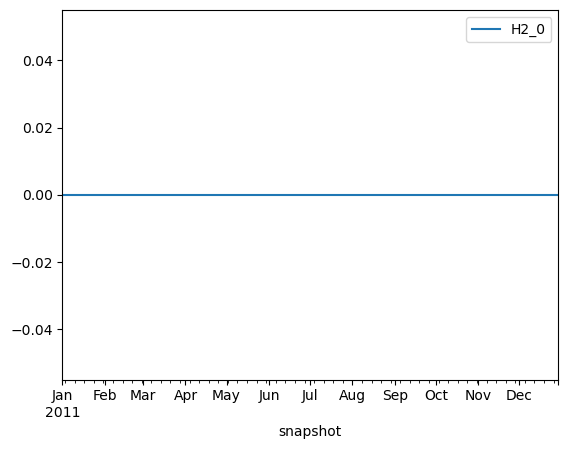

In [37]:
for key in networks:
    (networks[key].links_t.p1[networks[key].links.loc[networks[key].links.carrier=='H2_feedin'].index].sum(axis=1).resample('100h').mean()/1e3).plot(legend=True, label = key)

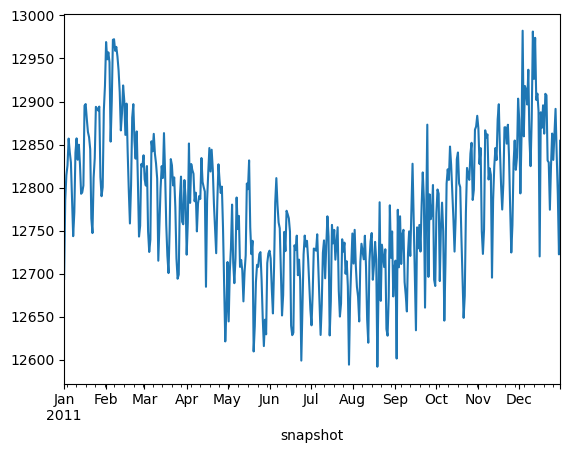

In [38]:
rel_h2_loads_carriers = ['H2_for_industry', 'H2_hgv_load']
for key in networks:
    networks[key].loads_t.p[networks[key].loads.loc[networks[key].loads.carrier=='H2_for_industry'].index].sum(axis=1).resample('20h').mean().plot()

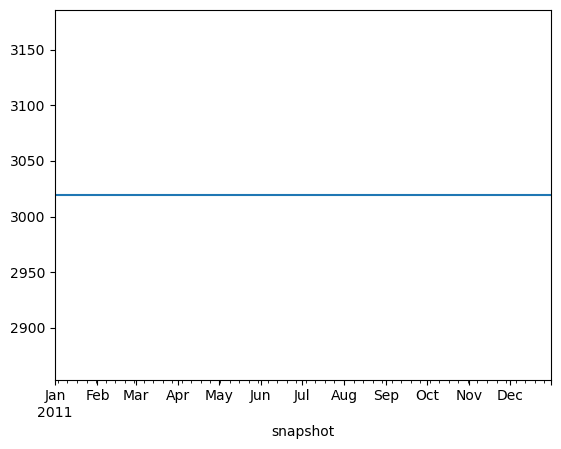

In [39]:
rel_h2_loads_carriers = ['H2_for_industry', 'H2_hgv_load']
for key in networks:
    networks[key].loads_t.p[networks[key].loads.loc[networks[key].loads.carrier=='H2_hgv_load'].index].sum(axis=1).resample('20h').mean().plot()

In [40]:
networks['H2_0'].links.loc[networks['H2_0'].links.carrier=='H2_to_power'].index

Index(['2848', '2849', '2850', '2851', '2852', '2853', '2854', '2855', '2856',
       '2857',
       ...
       '5881', '5882', '5883', '5884', '5885', '5886', '5887', '5888', '5890',
       '5891'],
      dtype='object', name='Link', length=374)

# H2 to CH4

## H2 feedin

In [41]:
h2_feedin_links = {}
feedin_dispatch = {}
ch4_links = {}
ch4_dispatch = {}

for key in networks:
    h2_feedin_links[key] = networks[key].links[(networks[key].links.carrier == "H2_feedin")]
    feedin_dispatch[key] = networks[key].links_t.p0[h2_feedin_links[key].index]
    ch4_links[key] = networks[key].links[(networks[key].links.carrier == "CH4")]
    ch4_dispatch[key] = (
        abs(networks[key].links_t.p0[ch4_links[key].index])
        + abs(networks[key].links_t.p1[ch4_links[key].index])
    )/2
    
    # print(label[key])
    # print(f'Total feedin capacity (static): {h2_feedin_links[key].p_nom.sum()/1e3:.2f} GW')
    # print(f'Maximal use (%): {feedin_dispatch[key].sum(axis = 1).max()/h2_feedin_links[key].p_nom.sum()*100:.3}')
    # print(f'Total use H2 feedin (TWh): {feedin_dispatch[key].sum(axis = 1).sum()/1e6:.2f}\n')

### Spatial repartition

C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\864646659.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


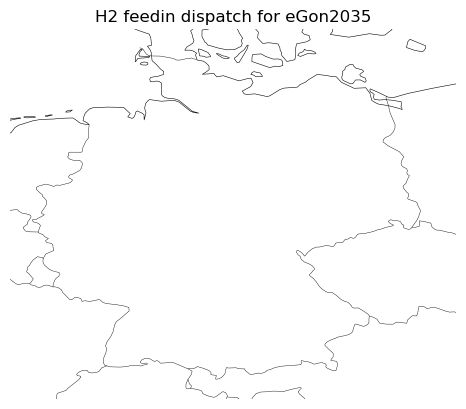

In [42]:
feedin_capacities = {}
feedin_H2_bus = {}
feedin_scaling = {}

for key in networks:

    feedin_H2_bus[key] = h2_feedin_links[key]["bus0"]
    feedin_capacities[key] = feedin_dispatch[key].sum(axis=0)
    new_idx = [feedin_H2_bus[key][i] for i in feedin_capacities[key].index.to_list()]
    feedin_capacities[key] = pd.Series(feedin_capacities[key].values,index = new_idx)
    feedin_scaling[key] = 1/feedin_capacities[key].max()

    network = networks[key].copy()
    network.buses = network.buses[(network.buses.carrier == "H2_grid")]

    fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})
    network.plot(
        bus_sizes=feedin_capacities[key] * feedin_scaling[key]/3,
        line_widths=0,
        link_widths=0,
        margin=0.1,
        ax=ax,
        title=("H2 feedin dispatch for "+label[key]),
    )
    fig.show()

### Share of methane flow

H2_vol2en = {
    0: 0,
    2: 0.00612,
    5: 0.01562,
    10: 0.03242,
    15: 0.05053,
    20: 0.07011,
}

In [43]:
rel_ch4_loads_carriers = ['rural_gas_boiler', 'CH4_for_industry', 'CH4']
rel_h2_loads_carriers = ['H2_for_industry', 'H2_hgv_load']

In [44]:
# for key in ["ch4_load_lim"]: #    " #  "cst_0_1": network_cst_0_1,
#     for i in h2_feedin_links[key].index: #[:1]: # h2_feedin_links[key].index: # ['4696']: #feedin_links[key].index: #
#         h2_bus_id = h2_feedin_links[key].at[i,"bus0"]
#         ch4_bus_id = h2_feedin_links[key].at[i,"bus1"]
#         feedin_at_ch4_bus = - networks[key].links_t.p1[i]

#         ch4_links_0 = networks[key].links[
#             (networks[key].links.carrier == "CH4")
#             & (networks[key].links.bus0 == ch4_bus_id)
#         ]
#         ch4_links_1 = networks[key].links[
#             (networks[key].links.carrier == "CH4")
#             & (networks[key].links.bus1 == ch4_bus_id)
#         ]

#         ch4_exchange = abs(
#             (networks[key].links_t.p0[ch4_links_0.index]).sum(axis = 1) 
#             - (networks[key].links_t.p1[ch4_links_1.index]).sum(axis = 1)
#         )
#         # ratio = feedin_at_ch4_bus/(feedin_at_ch4_bus+ch4_exchange)*100

#         # CH4 generation
#         ch4_gen_gen = networks[key].generators[
#             (networks[key].generators.bus == ch4_bus_id)
#             & ((networks[key].generators.carrier == "CH4_NG") | (networks[key].generators.carrier == "CH4_biogas"))
#         ]
#         ch4_gen_meth = networks[key].links[
#             (networks[key].links.carrier == "H2_to_CH4")
#             & (networks[key].links.bus1 == ch4_bus_id)
#         ]
#         ch4_gen = networks[key].generators_t.p[ch4_gen_gen.index].sum(axis = 1) - networks[key].links_t.p1[ch4_gen_meth.index].sum(axis = 1)
        
#         # ELY at H2 bus
#         ely_at_h2_bus = ELY[key][ELY[key]["bus1"] == h2_bus_id]
#         ely_at_h2_bus_dispatch = - networks[key].links_t.p1[ely_at_h2_bus.index].sum(axis = 1)

#         # H2 and CH4 loads
#         H2_loads = networks[key].loads[(networks[key].loads.bus == h2_bus_id) & (networks[key].loads.carrier.isin(rel_h2_loads_carriers))]
#         CH4_loads = networks[key].loads[(networks[key].loads.bus == ch4_bus_id) & (networks[key].loads.carrier.isin(rel_ch4_loads_carriers))]
#         h2_load_dispatch = networks[key].loads_t.p[H2_loads.index].sum(axis=1)
#         ch4_load_dispatch = networks[key].loads_t.p[CH4_loads.index].sum(axis=1)
        
#         # Static capacities (non optimized)
#         feedin_cap = h2_feedin_links[key].at[i,"p_nom"]
#         ch4_cap = ch4_links_1.p_nom.sum() + ch4_links_0.p_nom.sum()
#         ratio_cap = feedin_cap/ch4_cap

#         ch4_flow_total = ch4_exchange + ch4_load_dispatch + ch4_gen

#         # Plot
#         fig, ax1 = plt.subplots() #figsize=(15,5)
#         # fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
        
#         (feedin_at_ch4_bus/1e3).resample('20H').mean().plot(
#             ax=ax1, 
#             label = "H2 feedin",
#             # color='green',
#             # legend=True,
#         )
#         (ch4_flow_total/1e3).resample('20H').mean().plot(
#             ax=ax1, 
#             label = "Total CH4 flow (exchange through pipelines + loads + generation)",
#             # color='green',
#             # legend=True,
#         )
#         (ch4_exchange/1e3).resample('20H').mean().plot(
#             ax=ax1, 
#             label = "CH4 flow in gas pipelines", 
#             linestyle='dashed',
#             linewidth=0.8,
#             # legend=True,
#         )
#         (ch4_load_dispatch/1e3).resample('20H').mean().plot(
#             ax=ax1, 
#             label = "CH4 load",
#             linestyle='dashed',
#             linewidth=0.8,
#             # legend=True,
#         )
#         (ch4_gen/1e3).resample('20H').mean().plot(
#             ax=ax1, 
#             label = f"CH4 generation at CH4 bus ({ch4_bus_id}) (methanisation + extraction)",
#             linestyle='dashed',
#             linewidth=0.8,
#             # legend=True,
#         )
#         ax1.set_ylabel('GW')
#         ax1.set_title(
#             f"""
#                 Flow at CH4 bus {ch4_bus_id} {label[key]}
#                 Total p_nom CH4 =  {(ch4_cap/1e3):.2f} GW, p_nom H2 feedin = {(feedin_cap/1e3):.2f} GW, ratio p_nom = {ratio_cap:.3f}""", 
#                 fontsize=9,)
#         ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
#         fig.show()

In [45]:
# for key in ["cst_0_1"]: #    " #  "cst_0_1": network_cst_0_1,
#     for i in h2_feedin_links[key].index[:3]: #[:1]: # h2_feedin_links[key].index: # ['4696']: #feedin_links[key].index: #
#         h2_bus_id = h2_feedin_links[key].at[i,"bus0"]
#         ch4_bus_id = h2_feedin_links[key].at[i,"bus1"]
#         feedin_at_ch4_bus = - networks[key].links_t.p1[i]

#         ch4_links_0 = networks[key].links[
#             (networks[key].links.carrier == "CH4")
#             & (networks[key].links.bus0 == ch4_bus_id)
#         ]
#         ch4_links_1 = networks[key].links[
#             (networks[key].links.carrier == "CH4")
#             & (networks[key].links.bus1 == ch4_bus_id)
#         ]

#         ch4_exchange = abs(
#             (networks[key].links_t.p0[ch4_links_0.index]).sum(axis = 1) 
#             - (networks[key].links_t.p1[ch4_links_1.index]).sum(axis = 1)
#         )
#         # ratio = feedin_at_ch4_bus/(feedin_at_ch4_bus+ch4_exchange)*100

#         # CH4 generation
#         ch4_gen_gen = networks[key].generators[
#             (networks[key].generators.bus == ch4_bus_id)
#             & ((networks[key].generators.carrier == "CH4_NG") | (networks[key].generators.carrier == "CH4_biogas"))
#         ]
#         ch4_gen_meth = networks[key].links[
#             (networks[key].links.carrier == "H2_to_CH4")
#             & (networks[key].links.bus1 == ch4_bus_id)
#         ]
#         ch4_gen = networks[key].generators_t.p[ch4_gen_gen.index].sum(axis = 1) - networks[key].links_t.p1[ch4_gen_meth.index].sum(axis = 1)
        
#         # ELY at H2 bus
#         ely_at_h2_bus = ELY[key][ELY[key]["bus1"] == h2_bus_id]
#         ely_at_h2_bus_dispatch = - networks[key].links_t.p1[ely_at_h2_bus.index].sum(axis = 1)

#         # H2 and CH4 loads
#         H2_loads = networks[key].loads[(networks[key].loads.bus == h2_bus_id) & (networks[key].loads.carrier.isin(rel_h2_loads_carriers))]
#         CH4_loads = networks[key].loads[(networks[key].loads.bus == ch4_bus_id) & (networks[key].loads.carrier.isin(rel_ch4_loads_carriers))]
#         h2_load_dispatch = networks[key].loads_t.p[H2_loads.index].sum(axis=1)
#         ch4_load_dispatch = networks[key].loads_t.p[CH4_loads.index].sum(axis=1)
        
#         # Static capacities (non optimized)
#         feedin_cap = h2_feedin_links[key].at[i,"p_nom"]
#         ch4_cap = ch4_links_1.p_nom.sum() + ch4_links_0.p_nom.sum()
#         ratio_cap = feedin_cap/ch4_cap

#         ch4_flow_total = ch4_exchange + ch4_load_dispatch + ch4_gen

#         # Plot
#         fig, ax1 = plt.subplots() #figsize=(15,5)
#         # fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
        
#         (feedin_at_ch4_bus/1e3).resample('20H').mean().plot(
#             ax=ax1, 
#             label = "H2 feedin",
#             # color='green',
#             # legend=True,
#         )
#         (ch4_flow_total/1e3).resample('20H').mean().plot(
#             ax=ax1, 
#             label = "Total CH4 flow (exchange through pipelines + loads + generation)",
#             # color='green',
#             # legend=True,
#         )
#         (ch4_exchange/1e3).resample('20H').mean().plot(
#             ax=ax1, 
#             label = "CH4 flow in gas pipelines", 
#             linestyle='dashed',
#             linewidth=0.8,
#             # legend=True,
#         )
#         (ch4_load_dispatch/1e3).resample('20H').mean().plot(
#             ax=ax1, 
#             label = "CH4 load",
#             linestyle='dashed',
#             linewidth=0.8,
#             # legend=True,
#         )
#         (ch4_gen/1e3).resample('20H').mean().plot(
#             ax=ax1, 
#             label = f"CH4 generation at CH4 bus ({ch4_bus_id}) (methanisation + extraction)",
#             linestyle='dashed',
#             linewidth=0.8,
#             # legend=True,
#         )
#         ax1.set_ylabel('GW')
#         ax1.set_title(
#             f"""
#                 Flow at CH4 bus {ch4_bus_id} {label[key]}
#                 Total p_nom CH4 =  {(ch4_cap/1e3):.2f} GW, p_nom H2 feedin = {(feedin_cap/1e3):.2f} GW, ratio p_nom = {ratio_cap:.3f}""", 
#                 fontsize=9,)
#         ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
#         fig.show()

# CH4

## CH4 production

In [46]:
h2_feedin_links = {}
methanisation = {}
ch4_gen_abroad = {}
ch4_gen_DE = {}
ch4_gen = {}
ch4_gen_biogas = {}
ch4_gen_NG = {}

ch4_carriers = ['CH4', 'CH4_NG', 'CH4_biogas']
ch4_carriers_DE = ['CH4_NG', 'CH4_biogas']

for key in networks:
    # h2_feedin_links[key] = networks[key].links[(networks[key].links.carrier == "H2_feedin")]
    methanisation[key] = networks[key].links[(networks[key].links.carrier == "H2_to_CH4")]
    ch4_gen_abroad[key] = networks[key].generators[(networks[key].generators.carrier == "CH4")]
    ch4_gen_DE[key] = networks[key].generators[(networks[key].generators.carrier.isin(ch4_carriers_DE))]
    ch4_gen[key] = networks[key].generators[(networks[key].generators.carrier.isin(ch4_carriers))]
    ch4_gen_biogas[key] = networks[key].generators[(networks[key].generators.carrier == "CH4_biogas")]
    ch4_gen_NG[key] = networks[key].generators[(networks[key].generators.carrier == "CH4_NG")]

In [47]:
CH4_dispatch_methanisation = {}
# CH4_dispatch_H2_feedin = {}
CH4_gen_dispatch = {}
CH4_gen_dispatch_DE = {}
CH4_gen_dispatch_abroad = {}
CH4_store_dispatch = {}

for key in networks:
    CH4_dispatch_methanisation[key] = - networks[key].links_t.p1[methanisation[key].index]
    # CH4_dispatch_H2_feedin[key] = - networks[key].links_t.p1[h2_feedin_links[key].index]
    CH4_gen_dispatch[key] = networks[key].generators_t.p[[col for col in networks[key].generators_t.p.columns if 'CH4' in col]]
    CH4_gen_dispatch_DE[key] = networks[key].generators_t.p[ch4_gen_DE[key].index]
    CH4_gen_dispatch_abroad[key] = networks[key].generators_t.p[ch4_gen_abroad[key].index]
    CH4_store_dispatch[key] = networks[key].stores_t.p[[col for col in networks[key].stores_t.p.columns if 'CH4' in col]]

C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\1418048407.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


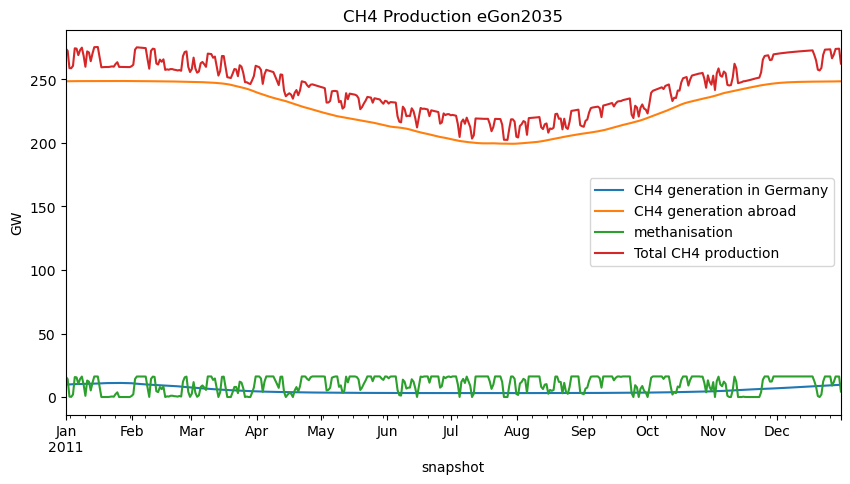

In [48]:
total_dispatch_ch4_prod = {}

for key in networks:
    fig, ax = plt.subplots(figsize = (10,5))
    total_dispatch_ch4_prod[key] = CH4_dispatch_methanisation[key].sum(axis = 1) + CH4_gen_dispatch[key].sum(axis = 1)
    # total_dispatch_ch4_prod[key] = CH4_dispatch_methanisation[key].sum(axis = 1) + CH4_dispatch_H2_feedin[key].sum(axis = 1) + CH4_gen_dispatch[key].sum(axis = 1)

    (CH4_gen_dispatch_DE[key]/1e3).sum(axis = 1).resample('20H').mean().plot(
        ax=ax, 
        label=("CH4 generation in Germany"), 
        legend=True
    )
    (CH4_gen_dispatch_abroad[key]/1e3).sum(axis = 1).resample('20H').mean().plot(
        ax=ax, 
        label=("CH4 generation abroad"), 
        legend=True
    )
    (CH4_dispatch_methanisation[key]/1e3).sum(axis = 1).resample('20H').mean().plot(
        ax=ax, label=("methanisation"), 
        legend=True
    )
    (total_dispatch_ch4_prod[key]/1e3).resample('20H').mean().plot(
        ax=ax, 
        label=("Total CH4 production"), 
        legend=True
    )
    # (CH4_dispatch_H2_feedin[key]/1e3).sum(axis = 1).resample('20H').mean().plot(ax=ax, label=("H2 feedin"), legend=True)
    # (CH4_gen_dispatch[key]/1e3).sum(axis = 1).resample('20H').mean().plot(ax=ax, label=("CH4 generation"), legend=True)
    # (CH4_store_dispatch[key]/1e3).sum(axis = 1).resample('20H').mean().plot(ax=ax, label=("CH4 store dispatch"), legend=True)

    ax.set_ylabel('GW')
    ax.set_title('CH4 Production '+label[key])

    fig.show()

C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\2365426412.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


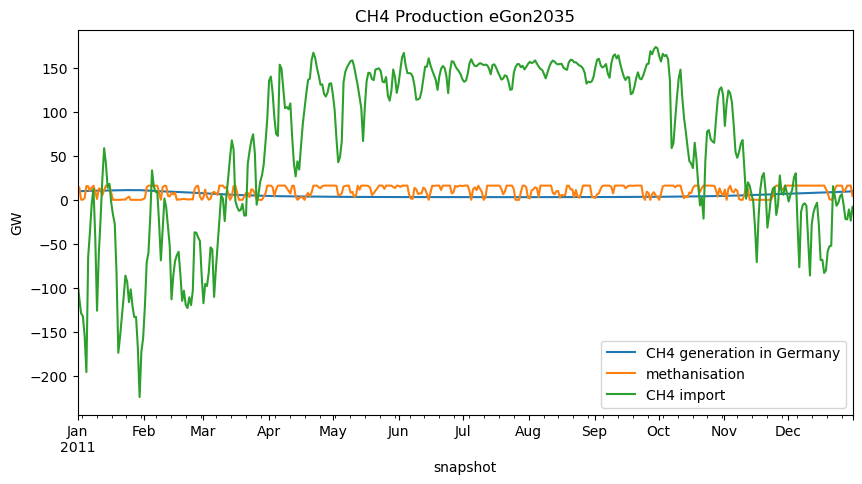

In [80]:
total_dispatch_ch4_prod = {}
abroad_CH4_loads = networks["H2_0"].loads[networks["H2_0"].loads.carrier == "CH4"]
# abroad_CH4_loads_t = networks["H2_0"].loads_t.p[abroad_CH4_loads.index].sum(axis=0)
for key in networks:
    fig, ax = plt.subplots(figsize = (10,5))
    total_dispatch_ch4_prod[key] = CH4_dispatch_methanisation[key].sum(axis = 1) + CH4_gen_dispatch[key].sum(axis = 1)
    abroad_demand = networks["H2_0"].loads_t.p[abroad_CH4_loads.index].sum(axis = 1)
    CH4_import = CH4_gen_dispatch_abroad[key].sum(axis = 1) - abroad_demand

    # total_dispatch_ch4_prod[key] = CH4_dispatch_methanisation[key].sum(axis = 1) + CH4_dispatch_H2_feedin[key].sum(axis = 1) + CH4_gen_dispatch[key].sum(axis = 1)

    (CH4_gen_dispatch_DE[key]/1e3).sum(axis = 1).resample('20H').mean().plot(
        ax=ax, 
        label=("CH4 generation in Germany"), 
        legend=True
    )
    # (CH4_gen_dispatch_abroad[key]/1e3).sum(axis = 1).resample('20H').mean().plot(
    #     ax=ax, 
    #     label=("CH4 generation abroad"), 
    #     legend=True
    # )
    (CH4_dispatch_methanisation[key]/1e3).sum(axis = 1).resample('20H').mean().plot(
        ax=ax, label=("methanisation"), 
        legend=True
    )
    (CH4_import/1e3).resample('20H').mean().plot(
        ax=ax, label=("CH4 import"), 
        legend=True
    )
    # (total_dispatch_ch4_prod[key]/1e3).resample('20H').mean().plot(
    #     ax=ax, 
    #     label=("Total CH4 production"), 
    #     legend=True
    # )
    # (CH4_dispatch_H2_feedin[key]/1e3).sum(axis = 1).resample('20H').mean().plot(ax=ax, label=("H2 feedin"), legend=True)
    # (CH4_gen_dispatch[key]/1e3).sum(axis = 1).resample('20H').mean().plot(ax=ax, label=("CH4 generation"), legend=True)
    # (CH4_store_dispatch[key]/1e3).sum(axis = 1).resample('20H').mean().plot(ax=ax, label=("CH4 store dispatch"), legend=True)

    ax.set_ylabel('GW')
    ax.set_title('CH4 Production '+label[key])

    fig.show()

In [85]:
abroad_CH4_loads = networks["H2_0"].loads[networks["H2_0"].loads.carrier == "CH4"]
# abroad_CH4_loads_t = networks["H2_0"].loads_t.p[abroad_CH4_loads.index].sum(axis=0)
abroad_demand = networks["H2_0"].loads_t.p[abroad_CH4_loads.index].sum().sum()
    # CH4_import = CH4_gen_dispatch_abroad[key].sum(axis = 1) - abroad_demand
abroad_demand/1e6

285.2310002842073

In [ ]:
CH4_gen_dispatch_abroad = networks["H2_0"].generators_t.p[ch4_gen_abroad["H2_0"].index].sum().sum()
CH4_gen_dispatch_abroad/1e6

In [89]:
(CH4_gen_dispatch_abroad - abroad_demand)/1e6
print(f"CH4 importiert in Deutschland: {(CH4_gen_dispatch_abroad - abroad_demand)/1e6} TWh")

CH4 importiert in Deutschland: 114.19491306652695 TWh


### Spatial repartition

#### Abroad

C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\3299911500.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


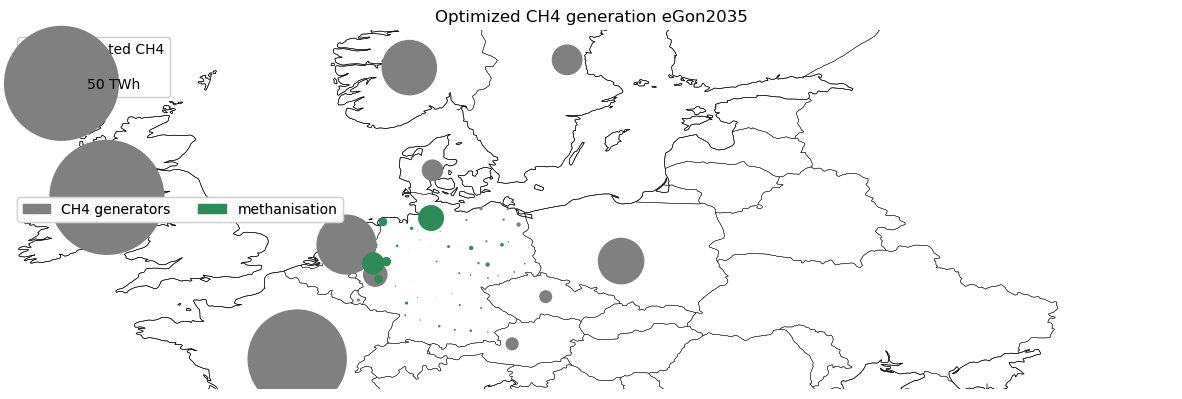

In [49]:
for key in networks:
    ch4_gen_capacities = networks[key].generators_t.p[ch4_gen[key].index].sum(axis=0)
    new_idx = [i.replace(' CH4_biogas','').replace(' CH4_NG','').replace(' CH4','') for i in ch4_gen_capacities.index.to_list()]
    ch4_gen_capacities = pd.Series(ch4_gen_capacities.values,index = new_idx).groupby(level=0).sum()

    ch4_meth_bus = methanisation[key]["bus1"]
    meth_capacities = CH4_dispatch_methanisation[key].sum(axis=0)
    meth_capacities.index =(ch4_meth_bus.values)
    # new_idx = [ch4_meth_bus[i] for i in meth_capacities.index.to_list()]
    # meth_capacities = pd.Series(ely_capacities_ac[key].values,index = new_idx).groupby(level=0).sum()
    
    ## Only abroad
    # ch4_gen_capacities = networks[key].generators_t.p[ch4_gen_abroad[key].index].sum(axis=0)
    # new_idx = [i.replace(' CH4','') for i in ch4_gen_capacities.index.to_list()]  # remove 'CH4' from index to be able to use network.plot
    # ch4_gen_capacities = pd.Series(ch4_gen_capacities.values,index = new_idx)

    # scaling = 1/ch4_gen_capacities.max()

    scaling = 5/1e6
    bus_scaling = 1/1e2
    bus_sizes_gen = ch4_gen_capacities * scaling
    bus_sizes_meth = meth_capacities * scaling
    bus_unit = "TWh"
 
    handles = make_legend_circles_for(
        # [bus_sizes.min()*bus_scaling, bus_sizes.max()*bus_scaling],
        [bus_sizes_gen.max()*bus_scaling, bus_sizes_meth.max()*bus_scaling], 
        scale=1, 
        facecolor="grey",# colors()["H2_to_CH4"]] #-> yellow :/
    )
    labels = [f"{round(bus_sizes.max())} " + bus_unit]
    # labels = [#"min", "max"]
    #     ("{} " + bus_unit).format(s)
    #     for s in (
    #         round(bus_sizes.min()),
    #         round(bus_sizes.max()),
    #     )
    # ]

    # network = networks[key].copy()
    # network.buses = network.buses[
    #     (network.buses.country != "RU")
    #     & (network.buses.carrier == "CH4")
    # ]
    fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()}, figsize = (15,7))
    networks[key].plot(
        bus_sizes=bus_sizes_gen * bus_scaling,
        line_widths=0,
        link_widths=0,
        margin=0.1,
        ax=ax,
        bus_colors="grey",#colors()["CH4"],
        # title = "Optimized CH4 generation "+label[key]
    )
    networks[key].plot(
        bus_sizes=bus_sizes_meth * bus_scaling,
        line_widths=0,
        link_widths=0,
        margin=0.1,
        ax=ax,
        bus_colors=colors()["H2_to_CH4"],
        title = "Optimized CH4 generation "+label[key],
    )
    
    l2 = ax.legend(
        handles,
        labels,
        loc='upper left',
        # bbox_to_anchor=(0.01, 1.01),
        labelspacing=1.5,
        framealpha=1.0,
        title="Total generated CH4",
        handler_map=make_handler_map_to_scale_circles_as_in(ax),
    )
    ax.add_artist(l2)
    
    handles = []
    color={"CH4 generators": "grey", "methanisation":colors()["H2_to_CH4"]}
    
    for i in ["CH4 generators", "methanisation"]:
        patch = mpatches.Patch(color=color[i], label=i)
        handles.append(patch)

    l3 = plt.legend(handles=handles, loc="center left", ncol=3,)# bbox_to_anchor=(-0.1, 0)
    ax.add_artist(l3)
    
    fig.show()

#### In Germany

C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\3214880607.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


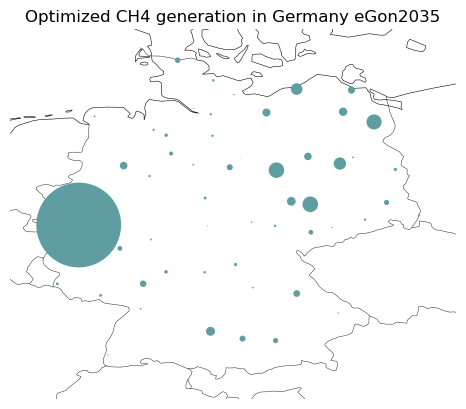

In [50]:
for key in networks:
    ch4_gen_capacities = networks[key].generators_t.p[ch4_gen_DE[key].index].sum(axis=0)

    new_idx = [i.replace(' CH4_biogas','').replace(' CH4_NG','') for i in ch4_gen_capacities.index.to_list()]  #.replace(' CH4_NG','')# remove 'CH4' from index to be able to use network.plot
    ch4_gen_capacities = pd.Series(ch4_gen_capacities.values,index = new_idx).groupby(level=0).sum()
    scaling = 1/ch4_gen_capacities.max()

    network = networks[key].copy()
    network.buses = network.buses[
        (network.buses.country == "DE")
        & (network.buses.carrier == "CH4")
    ]

    fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()}) #, figsize = (15,7)
    network.plot(
        bus_sizes=ch4_gen_capacities * scaling,
        line_widths=0,
        link_widths=0,
        margin=0.1,
        ax=ax,
        title = "Optimized CH4 generation in Germany "+label[key])
    
    fig.show()

### Constraint

In [51]:
print("Rq: Results are multiplied by 5 because of skip_snapshots\n")
for key in networks:
    ch4_gen_NG = networks[key].generators[networks[key].generators.carrier == "CH4_NG"]
    ch4_gen_NG_d = networks[key].generators_t.p[ch4_gen_NG.index].sum(axis=0)

    ch4_gen_biogas = networks[key].generators[networks[key].generators.carrier == "CH4_biogas"]
    ch4_gen_biogas_d = networks[key].generators_t.p[ch4_gen_biogas.index].sum(axis=0)

    print(f'Total NG produced in Germany ({label[key]}): {5*ch4_gen_NG_d.sum()/1e6:.2f} TWh')
    print(f'Total biogas produced in Germany ({label[key]}): {5*ch4_gen_biogas_d.sum()/1e6:.2f} TWh')

Rq: Results are multiplied by 5 because of skip_snapshots

Total NG produced in Germany (eGon2035): 36.00 TWh
Total biogas produced in Germany (eGon2035): 10.00 TWh


## CH4 uses

C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\2323555169.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


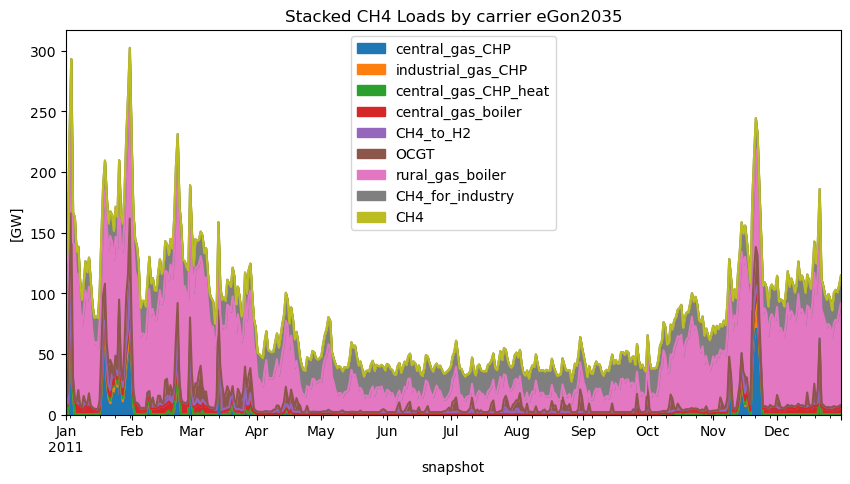

In [52]:
rel_ch4_links_carriers = network.links.loc[network.links.bus0.isin(network.buses.loc[network.buses.carrier == 'CH4'].index)].carrier.unique()
rel_ch4_links_carriers = np.delete(rel_ch4_links_carriers, np.where(rel_ch4_links_carriers == 'CH4'))
rel_ch4_loads_carriers = ['rural_gas_boiler', 'CH4_for_industry', 'CH4']

CH4_use = {}
total_dispatch_ch4_store = {}

for key in networks:
    # Links consuming CH4
    CH4_use[key] = networks[key].links_t.p0[networks[key].links.loc[networks[key].links.carrier == rel_ch4_links_carriers[0]].index.to_list()]
    CH4_use[key] = pd.DataFrame(CH4_use[key].sum(axis=1))
    CH4_use[key] = CH4_use[key].rename(columns={0:rel_ch4_links_carriers[0]})

    for i in rel_ch4_links_carriers[1:]:
        ch4_loads = networks[key].links_t.p0[networks[key].links.loc[networks[key].links.carrier == i].index.to_list()]
        CH4_use[key][i] = ch4_loads.sum(axis=1)

    # CH4 loads
    DE_loads = networks[key].loads.loc[networks[key].loads.bus.isin(buses_DE[key].index)]
    for i in rel_ch4_loads_carriers:
        ch4_loads = networks[key].loads_t.p[DE_loads.loc[DE_loads.carrier == i].index.to_list()]
        CH4_use[key][i] = ch4_loads.sum(axis=1)

    # Stores
    total_dispatch_ch4_store[key] = CH4_store_dispatch[key].sum(axis=1)
    
    # Plot
    fig = plt.figure(figsize=(10,5)) #, dpi=300
    (CH4_use[key].resample('20H').mean()/1e3).plot.area( #.area
        ax = plt.gca(), 
        title='Stacked CH4 Loads by carrier '+label[key], 
        ylabel = "[GW]", 
        legend=True, 
        stacked=True,
    )
    # ((total_dispatch_ch4_prod[key] + total_dispatch_ch4_store[key])/1e3).resample('20H').mean().plot(
    #     ax = plt.gca(), 
    #     legend = True, 
    #     label='Total generation and storage dispatch (CH4)', 
    #     color='black', 
    #     linestyle='dashed')
    
    fig.show()

C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\2917872857.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


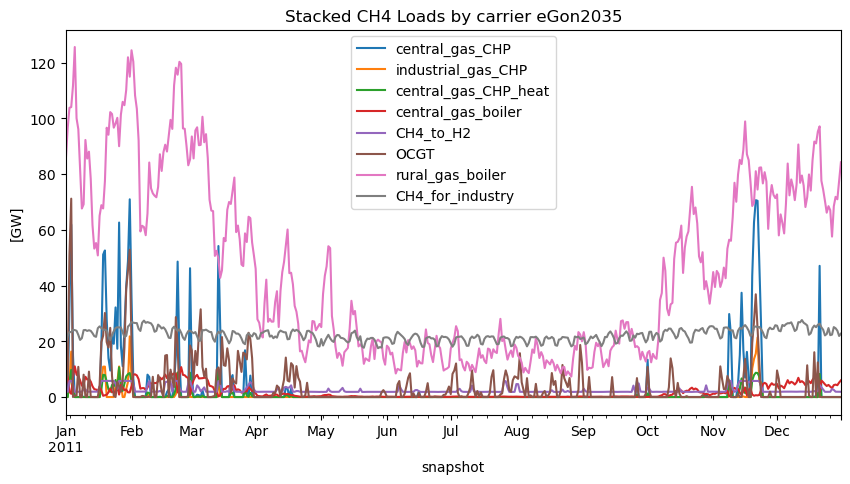

In [91]:
rel_ch4_links_carriers = network.links.loc[network.links.bus0.isin(network.buses.loc[network.buses.carrier == 'CH4'].index)].carrier.unique()
rel_ch4_links_carriers = np.delete(rel_ch4_links_carriers, np.where(rel_ch4_links_carriers == 'CH4'))
rel_ch4_loads_carriers = ['rural_gas_boiler', 'CH4_for_industry']#, 'CH4'

CH4_use = {}
total_dispatch_ch4_store = {}

for key in networks:
    # Links consuming CH4
    CH4_use[key] = networks[key].links_t.p0[networks[key].links.loc[networks[key].links.carrier == rel_ch4_links_carriers[0]].index.to_list()]
    CH4_use[key] = pd.DataFrame(CH4_use[key].sum(axis=1))
    CH4_use[key] = CH4_use[key].rename(columns={0:rel_ch4_links_carriers[0]})

    for i in rel_ch4_links_carriers[1:]:
        ch4_loads = networks[key].links_t.p0[networks[key].links.loc[networks[key].links.carrier == i].index.to_list()]
        CH4_use[key][i] = ch4_loads.sum(axis=1)

    # CH4 loads
    DE_loads = networks[key].loads.loc[networks[key].loads.bus.isin(buses_DE[key].index)]
    for i in rel_ch4_loads_carriers:
        ch4_loads = networks[key].loads_t.p[DE_loads.loc[DE_loads.carrier == i].index.to_list()]
        CH4_use[key][i] = ch4_loads.sum(axis=1)

    # Stores
    total_dispatch_ch4_store[key] = CH4_store_dispatch[key].sum(axis=1)
    
    # Plot
    fig = plt.figure(figsize=(10,5)) #, dpi=300
    (CH4_use[key].resample('20H').mean()/1e3).plot( #.area
        ax = plt.gca(), 
        title='Stacked CH4 Loads by carrier '+label[key], 
        ylabel = "[GW]", 
        legend=True, 
        # stacked=True,
    )
    # ((total_dispatch_ch4_prod[key] + total_dispatch_ch4_store[key])/1e3).resample('20H').mean().plot(
    #     ax = plt.gca(), 
    #     legend = True, 
    #     label='Total generation and storage dispatch (CH4)', 
    #     color='black', 
    #     linestyle='dashed')
    
    fig.show()

In [71]:
abroad_CH4_loads = networks["H2_0"].loads[networks["H2_0"].loads.carrier == "CH4"]
abroad_CH4_loads_t = networks["H2_0"].loads_t.p[abroad_CH4_loads.index].sum(axis=0)
abroad_CH4_loads

,bus,p_set,carrier,type,q_set,sign
Load,,,,,,
48621 CH4,48621,0.0,CH4,,0.0,-1.0
48622 CH4,48622,0.0,CH4,,0.0,-1.0
48623 CH4,48623,0.0,CH4,,0.0,-1.0
48624 CH4,48624,0.0,CH4,,0.0,-1.0
48625 CH4,48625,0.0,CH4,,0.0,-1.0
48626 CH4,48626,0.0,CH4,,0.0,-1.0
48627 CH4,48627,0.0,CH4,,0.0,-1.0
48628 CH4,48628,0.0,CH4,,0.0,-1.0
48629 CH4,48629,0.0,CH4,,0.0,-1.0


In [72]:
abroad_CH4_loads_t = networks["H2_0"].loads_t.p[abroad_CH4_loads.index].sum(axis=0)

In [73]:
abroad_CH4_loads_t

Load
48621 CH4    1.220878e+07
48622 CH4    2.253999e+07
48623 CH4    3.831187e+06
48624 CH4    1.743292e+07
48625 CH4    5.529875e+06
48626 CH4    5.794580e+07
48627 CH4    7.348684e+07
48628 CH4    1.304851e+06
48629 CH4    4.029057e+07
48630 CH4    5.076649e+06
48631 CH4    4.224327e+07
48632 CH4    3.340256e+06
dtype: float64

### Spatial repartition

C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\2761758573.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


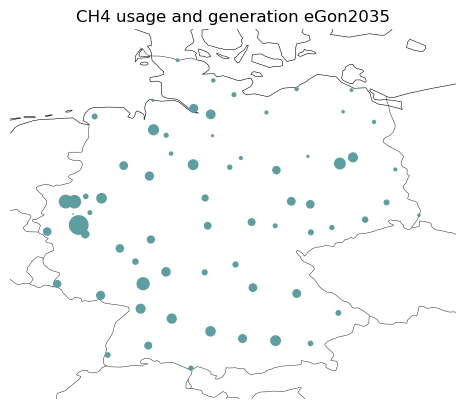

In [54]:
for key in networks:
    ch4_buses = networks[key].buses[networks[key].buses.carrier=='CH4'].index
    a = {}
    for i in ch4_buses:
        rel_links = networks[key].links.loc[(networks[key].links.bus0 == i) & (networks[key].links.carrier != 'CH4')].index
        b=(networks[key].links_t.p0.T.loc[rel_links].abs().sum().sum())
        rel_gens = networks[key].generators.loc[networks[key].generators.bus == i].index
        c=(networks[key].generators_t.p.T.loc[rel_gens].abs().sum().sum())
        rel_loads = networks[key].loads.loc[networks[key].loads.bus == i].index
        d=(networks[key].loads_t.p.T.loc[rel_loads].abs().sum().sum())
        a[i]=b+c+d

    fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})
    network.plot(
        bus_sizes=pd.Series(a)/max(pd.Series(a)),
        line_widths=0,
        link_widths=0,
        margin=0.1,
        ax=ax,
        title=("CH4 usage and generation "+label[key]),
    )
fig.show()

# Stores

eGon2035
CH4 total storage capacity in Germany:3.03e+02 TWh
CH4 Maximum fill in Germany (%): 78.3
H2_overground total storage capacity in Germany:0.0182 TWh
H2_overground Maximum fill in Germany (%): 99.9
H2_underground total storage capacity in Germany:0.000115 TWh
H2_underground Maximum fill in Germany (%): 62.7


C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\458112997.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


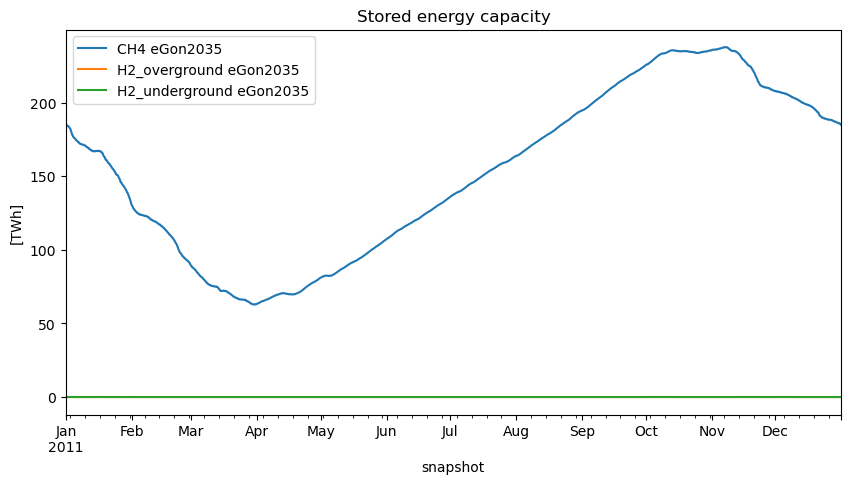

In [55]:
gas_stores_carriers = ['CH4', 'H2_overground', 'H2_underground']

for key in networks:
    print(label[key])
    for i in gas_stores_carriers:
        gas_stores_DE = networks[key].stores.loc[
            (networks[key].stores.carrier == i)
            & (networks[key].stores.bus.isin(buses_DE[key].index))
        ]

        print(f'{i} total storage capacity in Germany:{gas_stores_DE.e_nom_opt.sum()/1e6:.3} TWh')
        print(f'{i} Maximum fill in Germany (%): {networks[key].stores_t.e[gas_stores_DE.index].sum(axis = 1).max()/gas_stores_DE.e_nom_opt.sum()*100:.3}')
        
        (networks[key].stores_t.e[gas_stores_DE.index].sum(axis = 1)/1e6).plot(
            title = 'Stored energy capacity',
            figsize=(10,5), 
            ylabel='[TWh]',
            label = (i+" "+label[key]),
            legend= True,
        )
    fig.show()

## H2 storages

In [56]:
h2_stores_carriers = ['H2_overground', 'H2_underground']

In [57]:
for key in networks:
    print(key)
    for i in h2_stores_carriers:
        h2_stores = networks[key].stores.loc[
            (networks[key].stores.carrier == i)
        ]

        print(f'{i} total storage capacity:{h2_stores.e_nom_opt.sum():.2f} MWh')
        print(f'{i} Maximum fill (%): {networks[key].stores_t.e[h2_stores.index].sum(axis = 1).max()/h2_stores.e_nom_opt.sum()*100:.2f} \n')
        
        # (networks[key].stores_t.e[stores.index].sum(axis = 1)/1e6).plot(title = 'Current Storage energy capacity',figsize=(20,10), ylabel='[TWh]',label = i, legend= True)


H2_0
H2_overground total storage capacity:18227.46 MWh
H2_overground Maximum fill (%): 99.92 

H2_underground total storage capacity:115.27 MWh
H2_underground Maximum fill (%): 62.66 



C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\2527235017.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


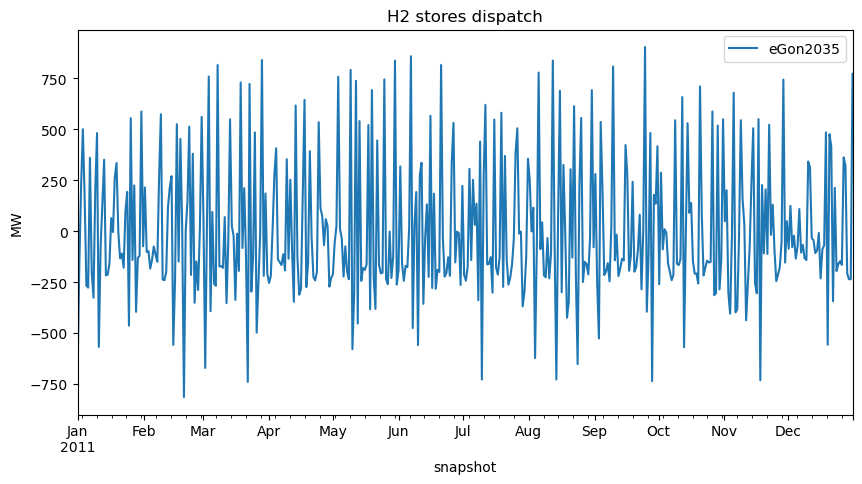

In [58]:
h2_stores = {}
h2_stores_dispatch = {}

fig, ax = plt.subplots(figsize = (10,5))

for key in networks: #["5H2share"]: # 

    h2_stores[key] = networks[key].stores.loc[networks[key].stores.carrier.isin(h2_stores_carriers)]
    h2_stores_dispatch[key] = networks[key].stores_t.p[h2_stores[key].index].sum(axis=1)
    
    (h2_stores_dispatch[key]).resample('20H').mean().plot(ax=ax, label=(label[key]), legend=True)

    ax.set_ylabel('MW')
    ax.set_title('H2 stores dispatch')

    fig.show()

### Spatial repartition

C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\1287994662.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


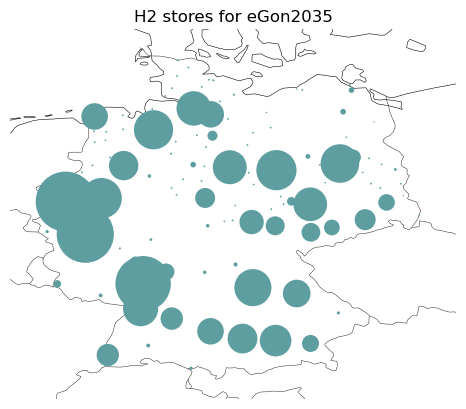

In [59]:
for key in networks:
    h2_store_cap = h2_stores[key].set_index("bus")["e_nom_opt"]

    network = networks[key].copy()
    network.buses = network.buses[(network.buses.carrier.isin(["H2_grid", "H2_saltcavern"]))]
    scaling = 1/h2_store_cap.max()

    fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})
    network.plot(
        bus_sizes=h2_store_cap * scaling/2,
        line_widths=0,
        link_widths=0,
        margin=0.1,
        ax=ax,
        title="H2 stores for "+label[key],
    )
    fig.show()

## CH4 stores

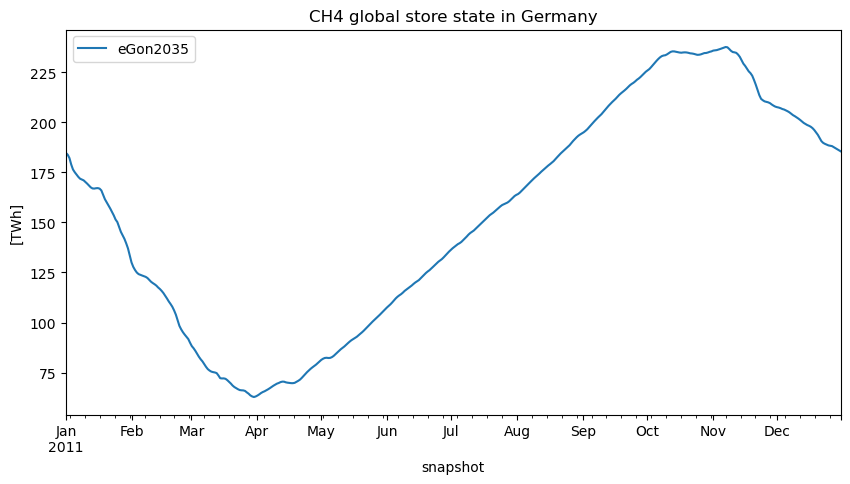

In [60]:
CH4_stores_DE = {}
CH4_stores_dispatch_DE = {}

for key in networks:
    CH4_stores_DE[key] = networks[key].stores.loc[(networks[key].stores.carrier=='CH4') & (networks[key].stores.bus.isin(buses_DE[key].index))]
    CH4_stores_dispatch_DE[key] = networks[key].stores_t.e[CH4_stores_DE[key].index].sum(axis=1) 

    (CH4_stores_dispatch_DE[key]/1e6).resample('20H').mean().plot(
        title = 'CH4 global store state in Germany',
        figsize=(10,5), 
        ylabel='[TWh]',
        label = label[key],
        legend= True,
    )

C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\2719839694.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


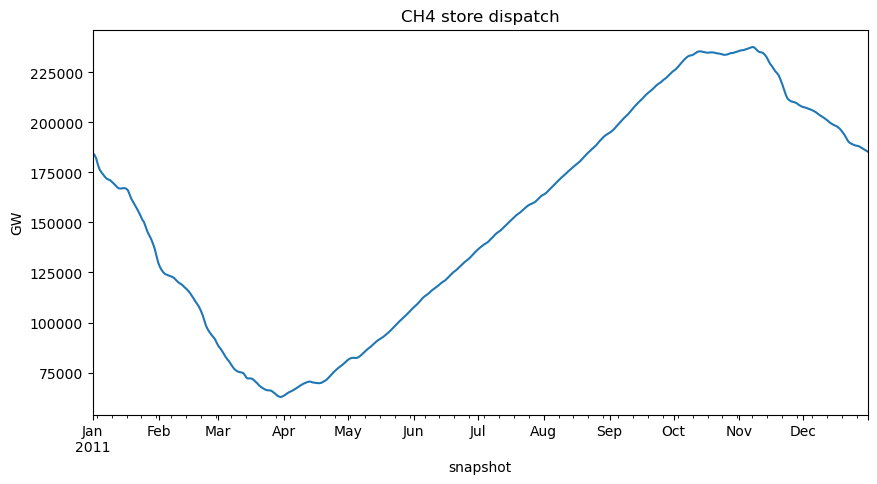

In [61]:
for key in networks:

    fig, ax = plt.subplots(figsize = (10,5))

    (CH4_stores_dispatch_DE[key]/1e3).resample('20H').mean().plot(
        title = 'CH4 store dispatch',
        ylabel='GW',
    )

    fig.show()

### Spatial repartition

C:\Users\nada_am\AppData\Local\Temp\ipykernel_6332\1442007224.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


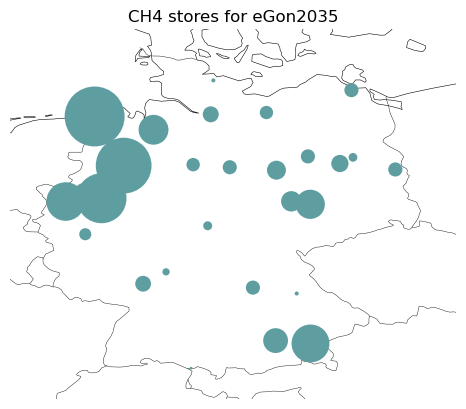

In [62]:
for key in networks:
    # ch4_store_cap = CH4_stores_DE[key][(CH4_stores[key].bus.isin(buses_DE[key].index))]
    ch4_store_cap = CH4_stores_DE[key].set_index("bus")["e_nom"]

    network = networks[key].copy()
    network.buses = network.buses[
        (network.buses.carrier == "CH4")
        & (network.buses.index.isin(buses_DE[key].index))
    ]
    scaling = 1/ch4_store_cap.max()

    fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})
    network.plot(
        bus_sizes=ch4_store_cap * scaling/2,
        line_widths=0,
        link_widths=0,
        margin=0.1,
        ax=ax,
        title="CH4 stores for "+label[key],
    )
    fig.show()

## Other stores

In [63]:
stores_exp = {}
for key in networks:
    stores_exp[key] = calc_storage_expansion_per_bus(networks[key])

In [64]:
# for key in networks:
#     store_ext = networks[key].stores[networks[key].stores.e_nom_extendable == True].groupby(['carrier']).sum().e_nom_opt
#     store_ext["battery"] = networks[key].storage_units[networks[key].storage_units.carrier == "battery"].p_nom_opt.sum()
#     store_ext = store_ext.sort_values()

#     fig, ax = plt.subplots()
#     # fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,) # figsize=(20,5)
#     (store_ext/1e3).plot.bar(ax)
#     ax.set_ylabel('MWh')
#     ax.set_title('Total optimized storages capacity')
#     ax.legend()
#     plt.show()

#     store_ext.pop("central_heat_store")

#     fig, ax = plt.subplots()

#     (store_ext/1e3).plot.bar(ax)
#     ax.set_ylabel('MWh')
#     ax.set_title('Total optimized storages capacity (without central heat stores)')
#     ax.legend()
#     plt.show()
